In [ ]:
!pip install dagster dagster-webserver yfinance pandas numpy matplotlib seaborn scikit-learn xgboost


In [ ]:
%%writefile -a dagster_pipeline.py

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dagster import asset, Definitions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


Appending to dagster_pipeline.py


In [ ]:
%%writefile -a dagster_pipeline.py

@asset
def fetch_data():
    df = yf.download("005930.KS", start="2018-01-01", end="2024-01-01")
    df.to_csv("samsung_raw.csv")
    return df

Appending to dagster_pipeline.py


In [ ]:
%%writefile -a dagster_pipeline.py
@asset
def clean_data(fetch_data):
    df = fetch_data.copy()
    df.dropna(inplace=True)
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df.to_csv("samsung_clean.csv")
    return df

Appending to dagster_pipeline.py


In [ ]:
%%writefile -a dagster_pipeline.py

@asset
def eda_report(clean_data):
    plt.figure(figsize=(10, 5))
    plt.plot(clean_data["Close"])
    plt.title("Samsung Closing Price Trend")
    plt.savefig("eda_close_price.png")
    plt.close()

    sns.heatmap(clean_data.corr(), cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.savefig("eda_correlation.png")
    plt.close()

    return "EDA Completed"


Appending to dagster_pipeline.py


In [ ]:
%%writefile -a dagster_pipeline.py

@asset
def feature_engineering(clean_data):
    df = clean_data.copy()
    df["MA_5"] = df["Close"].rolling(5).mean()
    df["MA_20"] = df["Close"].rolling(20).mean()
    df.dropna(inplace=True)

    X = df[["Open", "High", "Low", "Volume", "MA_5", "MA_20"]]
    y = df["Target"]

    return train_test_split(X, y, test_size=0.2, random_state=42)

Appending to dagster_pipeline.py


In [ ]:
%%writefile -a dagster_pipeline.py

@asset
def decision_tree_model(feature_engineering):
    X_train, X_test, y_train, y_test = feature_engineering
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))


@asset
def random_forest_model(feature_engineering):
    X_train, X_test, y_train, y_test = feature_engineering
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))


@asset
def xgboost_model(feature_engineering):
    X_train, X_test, y_train, y_test = feature_engineering
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))


@asset
def logistic_regression_model(feature_engineering):
    X_train, X_test, y_train, y_test = feature_engineering
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))


Appending to dagster_pipeline.py


In [ ]:
%%writefile -a dagster_pipeline.py

defs = Definitions(assets=[
    fetch_data,
    clean_data,
    eda_report,
    feature_engineering,
    decision_tree_model,
    random_forest_model,
    xgboost_model,
    logistic_regression_model
])

Appending to dagster_pipeline.py


In [ ]:
!dagster dev -f dagster_pipeline.py


/usr/local/lib/python3.12/dist-packages/click/core.py:824: SupersessionWarning: Function `dev_command` is superseded and its usage is discouraged. Use 'dg dev' instead.
  return callback(*args, **kwargs)
2026-01-15 11:14:47 +0000 - dagster - INFO - Using temporary directory /content/.tmp_dagster_home_n3cgtdhh for storage. This will be removed when dagster dev exits.
2026-01-15 11:14:47 +0000 - dagster - INFO - To persist information across sessions, set the environment variable DAGSTER_HOME to a directory to use.
2026-01-15 11:14:48 +0000 - dagster - INFO - Launching Dagster services...
2026-01-15 11:14:57 +0000 - dagster.daemon - INFO - Instance is configured with the following daemons: ['AssetDaemon', 'BackfillDaemon', 'FreshnessDaemon', 'QueuedRunCoordinatorDaemon', 'SchedulerDaemon', 'SensorDaemon']
2026-01-15 11:14:59 +0000 - dagster-webserver - INFO - Serving dagster-webserver on http://127.0.0.1:3000 in process 19046
2026-01-15 11:17:35 +0000 - dagster.daemon - INFO - Received i

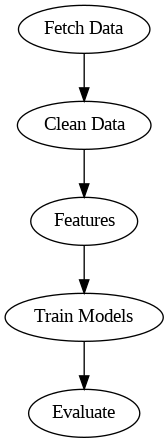

In [2]:
from graphviz import Digraph; from IPython.display import display, Image; g=Digraph(); g.edge("Fetch Data","Clean Data"); g.edge("Clean Data","Features"); g.edge("Features","Train Models"); g.edge("Train Models","Evaluate"); g.render("/mnt/data/dagster_graph", format="png", cleanup=True); display(Image("/mnt/data/dagster_graph.png"))
